In [1]:
import os
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
os.makedirs("../figures", exist_ok=True)

In [67]:
sns.set_style("ticks")
sns.set_theme(style=None)

plt.rcParams.update({
    'legend.title_fontsize': 8,
    'legend.fontsize': 8,
    'font.size': 8,
    'xtick.labelsize': 8,      # Size of x-axis tick labels
    'ytick.labelsize': 8,
    "axes.labelsize": 8,
    "font.family": "Nimbus Sans",       # or "Arial" / "Helvetica" if you use them
    "mathtext.fontset": "stixsans",   # make mathtext use same family
    "mathtext.default": "regular",      # normal upright font, not italic
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Figure 2

In previous version of this plot, results were poorer because not all ICD codes were available to be retieved, yet were evaluated as if they were. Hence there was a max recall < 1. Now recall can be 1 since those ICD codes were removed.

Take only "difficult" Phecodes, i.e. Phecodes with >10 ICD codes

In [3]:
# Load results and add meta-data
master_metrics_df = pd.read_parquet(
    '/sc/arion/projects/va-biobank/jamie/phecoder/results/phecodeX/metrics.parquet'
)
phecode_info = pd.read_parquet(
    '/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_info.parquet'
)
master_metrics_df = master_metrics_df.merge(phecode_info, on='phecode', how='left')
master_metrics_df["category_abbrev"] = master_metrics_df["phecode"].str.split("_").str[0]

# Normalize model names
master_metrics_df["model"] = master_metrics_df["model"].str.split("/").str[-1]

# --- add ensemble flag (True/False) ---
master_metrics_df["is_ensemble"] = master_metrics_df["model"].str.2tswith("ens", na=False)

# --- clean model names (remove any prefix before ':') ---
master_metrics_df["model"] = master_metrics_df["model"].str.split(":").str[-1]

# --- filter main results ---
metrics_df = master_metrics_df.query("n_gold_pos > 10 and model != 'gte-Qwen2-7B-instruct'")


Evaluation of individual LLMs:

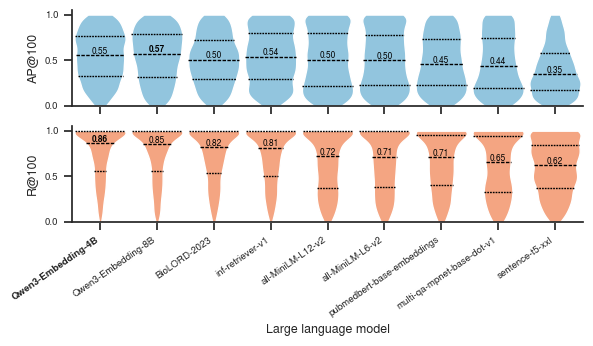

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metric_dict = {
    "Recall": "R@k",
    "AP": "AP@k"
}

# Define which (metric, k) pairs to plot
plots = [
    # ("AP", 10),
    # ("Recall", 10),
    # ("AP", 20),
    # ("Recall", 20),
    ("AP", 100),
    ("Recall", 100),
]

# Sort
sort_by = "Recall@100"  # e.g. "AP@20", "Recall@100"
metric_sort, k_sort = sort_by.split("@")
k_sort = int(k_sort)
sort_col = metric_dict[metric_sort]
order_global = (
    metrics_df[(metrics_df["k"] == k_sort) & (~metrics_df["is_ensemble"])]
    .groupby("model")[sort_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)
# ---------------------------------------------------------------------
fig, axes = plt.subplots(len(plots), 1, figsize=(6, 3.5), sharex=True, sharey=True)

for ax, (metric, k) in zip(axes, plots):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = rf"{metric_caps}@{k}"

    metric_df_temp = metrics_df[(metrics_df["k"] == k) & (~metrics_df["is_ensemble"])]

    # colour by metric (colorblind safe https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3)
    if metric=='AP':
        color='#92c5de'
    elif metric=='Recall':
        color='#f4a582'

    sns.violinplot(
        data=metric_df_temp,
        x="model",
        y=metric_dict[metric],
        order=order_global,
        inner="quartile",
        cut=0,
        width=0.9,
        density_norm="count",
        ax=ax,
        color=color,
        linewidth=1,
        edgecolor=None,
        saturation=1,
        inner_kws={"color": "black"}
    )

    # medians
    medians = metric_df_temp.groupby("model")[metric_dict[metric]].median().reindex(order_global)
    max_model = medians.idxmax()   # model with largest median
    for i, model in enumerate(order_global):
        y_med = medians.loc[model]
        ax.annotate(
            f"{y_med:.2f}",
            xy=(i, y_med),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="center",
            fontsize=6,
            fontweight="bold" if model == max_model else "normal",
            color="black",
            # bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="None", lw=0.2, alpha=0.8),
            zorder=10,
            clip_on=False,
        )

    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel("Large language model", fontsize=9)
    ax.set_ylabel(metric_k, fontsize=9)
    plt.xticks(rotation=35, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=7)

for label in ax.get_xticklabels():
    if label.get_text() == max_model:
        label.set_fontweight("bold")

plt.tight_layout()

# save 
for extension in ['png', 'pdf']:
    plt.savefig(f"../figures/mai|base_performance.{extension}", dpi=300)

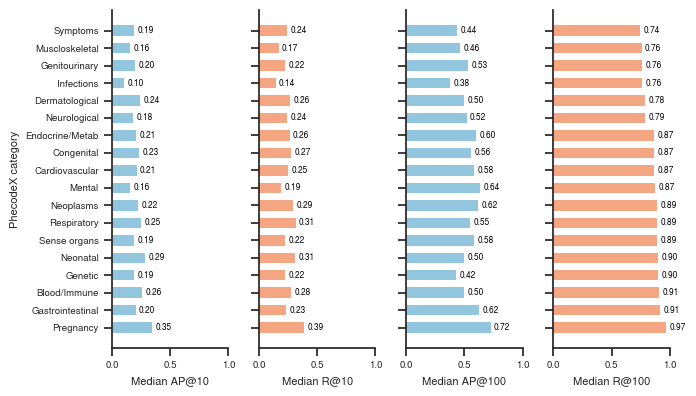

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric_dict = {"Recall": "R@k", "AP": "AP@k"}

best_model = "Qwen3-Embedding-4B"
metrics_best = metrics_df[metrics_df["model"] == best_model]

# --- added: fixed category order by Recall@100 ---
order_metric, order_k = "Recall", 100
order_col = metric_dict[order_metric]
cat_order = (
    metrics_best[metrics_best["k"] == order_k]
    .groupby("category")[order_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

plots = [
    ("AP", 10),
    ("Recall", 10),
    ("AP", 100),
    ("Recall", 100),
    # ("AP", 1000),
    # ("Recall", 1000),
]

fig, axes = plt.subplots(1, len(plots), figsize=(7, 4), sharey=True)
axes = axes.flatten()

for i, (ax, (metric, k)) in enumerate(zip(axes, plots)):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = f"Median {metric_caps}@{k}"
    
    df_temp = metrics_best[metrics_best["k"] == k]

    # --- changed: compute medians then reindex to cat_order ---
    medians = df_temp.groupby("category")[metric_dict[metric]].median()
    medians = medians.reindex(cat_order)
    categories = medians.index.tolist()
    values = medians.values

    # bar color
    color = "#92c5de" if metric == "AP" else "#f4a582"

    # horizontal barplot
    ax.barh(categories, values,
            color=color, edgecolor='none',
            height=0.6)

    # annotate bars with values
    for y, val in zip(categories, values):
        ax.text(val + 0.03, y, f"{val:.2f}",
                va="center", ha="left", fontsize=6, color="black")

    # axis labels
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric_k, fontsize=8)  # <-- removed stray 'm'
    if i==0:
        ax.set_ylabel(f'PhecodeX category', fontsize=8)
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=7)

# layout
plt.tight_layout()

# save
for extension in ['png', 'pdf']:
    plt.savefig(f"../figures/main_category_bars.{extension}", dpi=300, bbox_inches='tight')


# Figure 3

In [12]:
from phecoder.utils import load_results

results_dir = "/sc/arion/projects/va-biobank/jamie/phecoder/results/phecodeX"
phecode_ground_truth = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_icd_pairs.parquet')

# used to select Phecode size > 10 from earlier figure
phecodes = metrics_df['phecode'].unique()

sim_df = load_results(output_dir=results_dir, phecode_ground_truth=phecode_ground_truth, include_ensembles=False)
sim_df["model"] = sim_df["model"].str.split("/").str[-1]

Function to compute median Jaccard Index across Phecodes

In [16]:
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

def compare_models_jaccard(sim_df: pd.DataFrame, phecodes=None, K: int = 1000):
    """
    Compute pairwise Jaccard@K overlap between models across phecodes.

    Parameters
    ----------
    sim_df : pd.DataFrame
        Long-format similarity results (columns: model, phecode, icd_code, rank)
    phecodes : list[str], optional
        Restrict to these phecodes.
    K : int
        Top-K cutoff for overlap computation.

    Returns
    -------
    pd.DataFrame
        Pairwise Jaccard@K scores averaged across phecodes.
    """
    df = sim_df.copy()
    if phecodes is not None:
        df = df[df["phecode"].isin(phecodes)]
    df = df[df["rank"] <= K]

    models = sorted(df["model"].unique())
    pairs = list(combinations(models, 2))
    out = []

    for phe, sub in df.groupby("phecode", sort=False):
        lists = {
            m: set(sub.loc[sub["model"] == m, "icd_code"])
            for m in models
        }
        for a, b in pairs:
            la, lb = lists[a], lists[b]
            if not la or not lb:
                continue
            jac = len(la & lb) / len(la | lb)
            out.append({
                "phecode": phe,
                "model_a": a,
                "model_b": b,
                f"Jaccard@{K}": jac,
            })
    df_out = pd.DataFrame(out)
    return (
        df_out
        .groupby(["model_a", "model_b"], as_index=False)
        [f"Jaccard@{K}"].median()
        .pivot(index="model_a", columns="model_b", values=f"Jaccard@{K}")
    )


In [17]:
K = 100

# --- Compute symmetric matrices ---
jaccard_known = compare_models_jaccard(
    sim_df[sim_df["is_known"] == 1], phecodes=phecodes, K=K
)
jaccard_novel = compare_models_jaccard(
    sim_df[sim_df["is_known"] == 0], phecodes=phecodes, K=K
)

known = jaccard_known.combine_first(jaccard_known.T)
novel = jaccard_novel.combine_first(jaccard_novel.T)
np.fill_diagonal(known.values, np.nan)  # blank out diagonal
np.fill_diagonal(novel.values, np.nan)

Below, models are grouped based on their average retrieval overlap across both validated and novel ICD spaces.

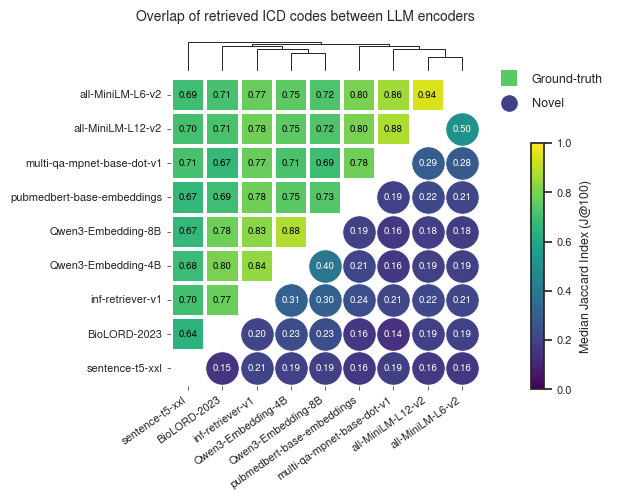

In [18]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns

# --- clustering on blended similarity (same as before) ---
M = 0.5 * (known.fillna(1.0) + novel.fillna(1.0))
np.fill_diagonal(M.values, 1.0)
D = (1.0 - M).clip(0, 1)
Z = linkage(squareform(D.values, checks=True), method="average")

# Use the *exact* leaf order that the dendrogram uses
order_info = dendrogram(Z, no_plot=True)
leaf_idx = order_info["leaves"]
order = M.index.to_numpy()[leaf_idx].tolist()

# Reorder matrices
known = known.loc[order, order]
novel = novel.loc[order, order]
models = order
n = len(models)

# --- Figure: one main axis for heatmap; dendrogram as an inset tied to it ---
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle("Overlap of retrieved ICD codes between LLM encoders", fontsize=10, y=0.87)

# Masks
mask_upper = np.tril(np.ones_like(known, dtype=bool))
mask_lower = np.triu(np.ones_like(known, dtype=bool))

# Lower triangle (squares)
sns.heatmap(
    known, mask=mask_lower, cmap="viridis", vmin=0, vmax=1,
    square=True, linewidths=1.5, cbar=False,
    annot=True, annot_kws={"size": 7, "color": "black"},
    fmt=".2f", ax=ax
)

# Upper triangle (circles)
for i in range(n):
    for j in range(i + 1, n):
        val = novel.iloc[i, j]
        if np.isfinite(val):
            ax.scatter(j + 0.5, i + 0.5, s=575,
                       facecolor=plt.cm.viridis(val),
                       edgecolor="white", linewidth=0.5)
            ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                    ha="center", va="center", fontsize=7, color="white")

# ---- TOP DENDROGRAM aligned to heatmap data area ----
# Make an inset axis that sits directly above the heatmap's DATA region
ax_dend = ax.inset_axes([0.0, 1.02, 1.0, 0.1], transform=ax.transAxes)  # [left, bottom, width, height] in axes coords

# Get dendrogram coordinates without plotting
ddata = dendrogram(Z, no_plot=True, color_threshold=0, above_threshold_color="dimgray")

# Map SciPy's leaf centers [5,15,25,...] to our heatmap centers [0.5, 1.5, ..., n-0.5]
x_orig_centers = np.linspace(5, 5 + 10*(n-1), n)
x_target_centers = np.arange(n) + 0.5
scale = (x_target_centers[-1] - x_target_centers[0]) / (x_orig_centers[-1] - x_orig_centers[0])
shift = x_target_centers[0] - x_orig_centers[0] * scale
icoord_scaled = [[x * scale + shift for x in ico] for ico in ddata["icoord"]]

# Draw dendrogram lines in the inset axis
for ico, dco in zip(icoord_scaled, ddata["dcoord"]):
    ax_dend.plot(ico, dco, linewidth=0.6, color='black')

ax_dend.set_xlim(0, n)     # share the same data span
ax_dend.axis("off")        # hide ticks/spines so only branches remain

# --- Colorbar ---
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, 1))
cbar = fig.colorbar(sm, ax=ax, anchor=(0, 0.4), fraction=0.04, pad=-0.15)
cbar.set_label(r"Median Jaccard Index ($J@100$)", fontsize=9)

# --- Labels & styling (unchanged) ---
ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.tick_params(length=3, width=0.5)
ax.set_xticklabels(models, rotation=35, ha="right")
ax.set_yticklabels(models, rotation=0)
ax.invert_yaxis()

# --- Legend (unchanged) ---
mean_known = np.nanmedian(known.values)
mean_novel = np.nanmedian(novel.values)
handles = [
    plt.Line2D([], [], marker='s', linestyle='None',
               markerfacecolor=plt.cm.viridis(mean_known), markeredgewidth=0,
               markersize=12, label='Ground-truth'),
    plt.Line2D([], [], marker='o', linestyle='None',
               markerfacecolor=plt.cm.viridis(mean_novel), markeredgewidth=0,
               markersize=12, label='Novel')
]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.44, 1.05),
          frameon=False, labelspacing=1.0, fontsize=9)

# save 
for extension in ['png', 'pdf']:
    plt.savefig(f"../figures/jaccard.{extension}", dpi=300)


# Figure 4

/tmp/ipykernel_1726039/2907439090.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bottom.set_xticklabels(new_labels, rotation=25, ha="right", fontsize=8)


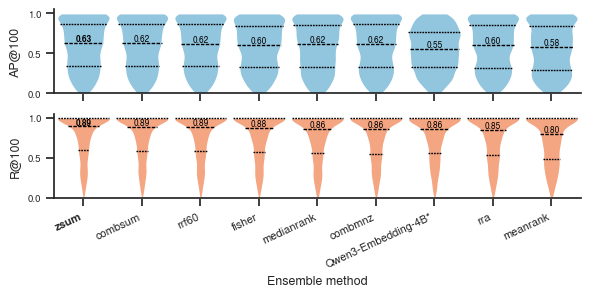

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

extra_models = ['Qwen3-Embedding-4B']

metric_dict = {
    "Recall": "R@k",
    "AP": "AP@k"
}

# Define which (metric, k) pairs to plot
plots = [
    # ("AP", 5),
    # ("Recall", 5),
    # ("AP", 10),
    # ("Recall", 10),
    # ("AP", 20),
    # ("Recall", 20),master_met
    # ("AP", 50),
    # ("Recall", 50),
    ("AP", 100),
    ("Recall", 100),
]

# Sort
sort_by = "Recall@100"  # e.g. "AP@20", "Recall@100"
metric_sort, k_sort = sort_by.split("@")
k_sort = int(k_sort)
sort_col = metric_dict[metric_sort]
order_global = (
    metrics_df[(metrics_df["k"] == k_sort) & (metrics_df["is_ensemble"] | metrics_df["model"].isin(extra_models))]
    .groupby("model")[sort_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# ---------------------------------------------------------------------
fig, axes = plt.subplots(len(plots), 1, figsize=(6, 3), sharex=True, sharey=True)

for ax, (metric, k) in zip(axes, plots):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = rf"{metric_caps}@{k}"

    metric_df_temp = metrics_df[(metrics_df["k"] == k) & (metrics_df["is_ensemble"] | metrics_df["model"].isin(extra_models))]

    # colour by metric (colorblind safe https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3)
    if metric=='AP':
        color='#92c5de'
    elif metric=='Recall':
        color='#f4a582'

    sns.violinplot(
        data=metric_df_temp,
        x="model",
        y=metric_dict[metric],
        order=order_global,
        inner="quartile",
        cut=0,
        width=0.9,
        density_norm="count",
        ax=ax,
        color=color,
        linewidth=1,
        edgecolor=None,
        saturation=1,
        inner_kws={"color": "black"}
    )

    # medians
    medians = metric_df_temp.groupby("model")[metric_dict[metric]].median().reindex(order_global)
    max_model = medians.idxmax()   # model with largest median
    for i, model in enumerate(order_global):
        y_med = medians.loc[model]
        ax.annotate(
            f"{y_med:.2f}",
            xy=(i, y_med),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="center",
            fontsize=6,
            fontweight="bold" if model == max_model else "normal",
            color="black",
            # bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="None", lw=0.2, alpha=0.8),
            zorder=10,
            clip_on=False,
        )

    ax.set_ylim(0.0, 1.05)
    ax.set_xlabel("Ensemble method", fontsize=9)
    ax.set_ylabel(metric_k, fontsize=9)
    plt.xticks(rotation=25, ha="right", fontsize=8)
    ax.tick_params(axis="y", labelsize=7)

for label in ax.get_xticklabels():
    if label.get_text() == max_model:
        label.set_fontweight("bold")

plt.tight_layout()

ax_bottom = axes[-1]  # only bottom plot shows x-labels
labels = [t.get_text() for t in ax_bottom.get_xticklabels()]
new_labels = [lbl + "*" if lbl in extra_models else lbl for lbl in labels]
ax_bottom.set_xticklabels(new_labels, rotation=25, ha="right", fontsize=8)

for extension in ['png', 'pdf']:
    plt.savefig(f"../figures/main_ensemble_performance.{extension}", dpi=300, bbox_inches='tight')

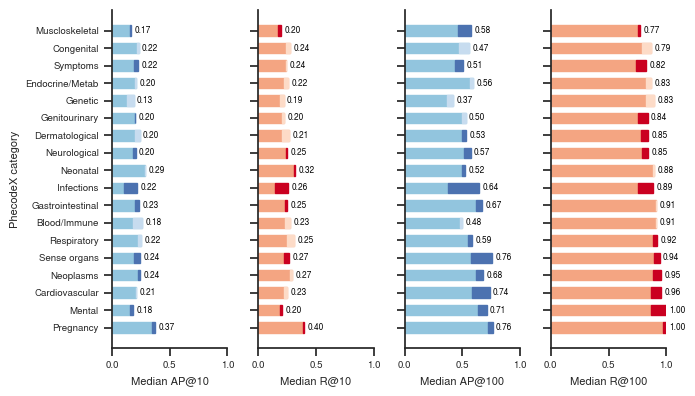

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric_dict = {"Recall": "R@k", "AP": "AP@k"}

base_model = "Qwen3-Embedding-4B"
ens_model  = "zsum"  # adjust if your zsum label differs

df_base = metrics_df[metrics_df["model"] == base_model].copy()
df_ens  = metrics_df[metrics_df["model"].str.contains("zsum", case=False, na=False)].copy()

# --- NEW: fixed category order based on zsum's Recall@100 ---
order_metric, order_k = "Recall", 100
order_col = metric_dict[order_metric]
cat_order = (
    df_ens[df_ens["k"] == order_k]
    .groupby("category")[order_col]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

plots = [
    ("AP", 10),
    ("Recall", 10),
    ("AP", 100),
    ("Recall", 100),
    # ("AP", 1000),
    # ("Recall", 1000),
]

fig, axes = plt.subplots(1, len(plots), figsize=(7, 4), sharey=True)
axes = axes.flatten()

for i, (ax, (metric, k)) in enumerate(zip(axes, plots)):

    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = f"Median {metric_caps}@{k}"

    df_base_k = df_base[df_base["k"] == k]
    df_ens_k  = df_ens[df_ens["k"] == k]

    med_base = df_base_k.groupby("category")[metric_dict[metric]].median()
    med_ens  = df_ens_k.groupby("category")[metric_dict[metric]].median()

    # align categories and reindex to fixed order from zsum Recall@100
    common = [c for c in cat_order if c in med_base.index and c in med_ens.index]
    med_base = med_base.reindex(common)
    med_ens  = med_ens.reindex(common)

    # delta
    delta = med_ens - med_base

    # base color
    base_color = "#92c5de" if metric == "AP" else "#f4a582"
    darker     = "#4c72b0" if metric == "AP" else "#ca0020"
    lighter    = "#c7dcef" if metric == "AP" else "#fddbc7"

    # draw base bars
    ax.barh(common, med_base,
            color=base_color, edgecolor=base_color, #linewidth=0.7,
            height=0.6, label="Base")

    # overlay only the delta segment
    for y, base_val, d in zip(common, med_base, delta):
        new_val = base_val + d  # final ensemble value for annotation
        if d > 0:  # improvement: extend bar to the right
            ax.barh(y, d, left=base_val, color=darker, height=0.6, edgecolor=darker)
            ax.text(new_val + 0.03, y, f"{new_val:.2f}",
                    va="center", ha="left", fontsize=6, color="black")
        elif d < 0:  # worse: overlay lighter segment (shorter bar)
            ax.barh(y, abs(d), left=base_val + d, color=lighter, height=0.6, edgecolor=lighter)
            ax.text(base_val + 0.03, y, f"{new_val:.2f}",
                    va="center", ha="left", fontsize=6, color="black")

    # axes setup
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric_k, fontsize=8)
    if i == 0:
        ax.set_ylabel("PhecodeX category", fontsize=8)
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=7)

plt.tight_layout()

for ext in ['png', 'pdf']:
    plt.savefig(f"../figures/main_category_bars_ensemble.{ext}", dpi=300, bbox_inches='tight')


# Figure 5

In [83]:
all_sets = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/sets_tidy.csv')
all_sizes = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/set_sizes.csv')
set_descriptions = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/set_descriptions.csv')
merged = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/merged_phecoder_output.csv')

/tmp/ipykernel_374293/445948437.py:4: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv('/sc/arion/projects/va-biobank/jamie/phecoder/validation/sets/merged_phecoder_output.csv')


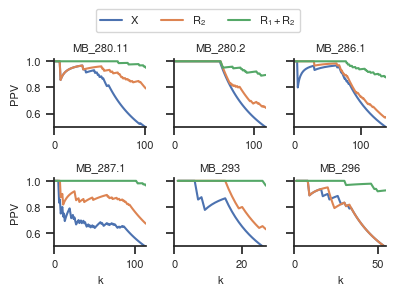

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

trunc = merged[(merged["retrieved"] == 1) & (merged["model"] == "zsum")].copy()

def compute_ppv(df, condition, label):
    df = df.copy()
    df["is_rel"] = df.eval(condition).astype(int)

    ppv_list = []
    for phecode, sub in df.groupby("phecode"):
        sub = sub.sort_values("rank")
        total = 0
        rel = 0
        for _, row in sub.iterrows():
            total += 1
            rel += row["is_rel"]
            ppv_list.append((phecode, total, rel / total))

    ppv_df = pd.DataFrame(ppv_list, columns=["phecode", "rank", "PPV"])
    ppv_df["Type"] = label
    return ppv_df

# Compute cumulative PPVs
ppv_known = compute_ppv(trunc, "is_known == 1", "X")
ppv_strict = compute_ppv(trunc, "relevant == 2", r"$R_2$")
ppv_extended = compute_ppv(trunc, "relevant in [1,2]", r"$R_1+R_2$")

ppv_all = pd.concat([ppv_known, ppv_strict, ppv_extended], ignore_index=True)

# --- Plot ---

g = sns.FacetGrid(
    ppv_all,
    col="phecode",
    hue="Type",
    sharey=True,
    sharex=False,
    col_wrap=3,
    height=1.5,
    aspect=1
)

g.map_dataframe(sns.lineplot, x="rank", y="PPV", linewidth=1.5)
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),  # position above grid
    ncol=3,                      # number of columns for legend items
    frameon=True,
    fontsize=8,                  # smaller font
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("k", "PPV")

# --- Custom per-axis limits ---
max_ranks = ppv_all.groupby("phecode")["rank"].max().to_dict()
for ax in g.axes.flat:
    phecode = ax.get_title().split()[0]
    if phecode in max_ranks:
        ax.set_xlim(0, max_ranks[phecode])
    # ax.axhline(0.5, color="gray", ls="--", lw=1, alpha=0.6)
    ax.set_ylim(0.5, 1.02)

desired_width = 4
current_size = g.fig.get_size_inches()
scale_factor = desired_width / current_size[0]
g.fig.set_size_inches(desired_width, current_size[1] * scale_factor, forward=True)

plt.tight_layout()

# for ext in ['png', 'pdf']:
#     plt.savefig(f"../figures/val_ppv.{ext}", dpi=300, bbox_inches='tight')


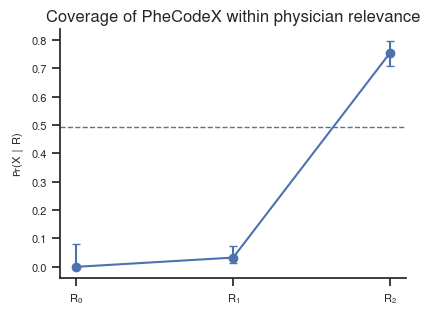

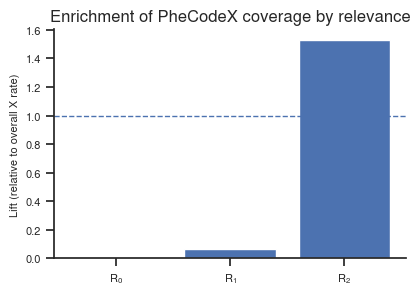

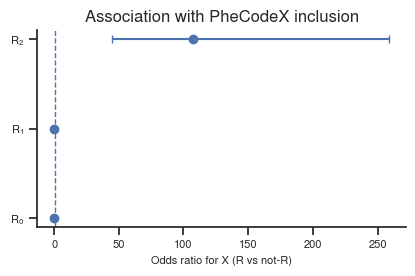

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# starting from your `d` (has columns: phecode, rel_num in {0,1,2}, is_x in {0,1})
df = d.copy()

# --- 1) Proportion of X within each relevance level -------------------
tab = (df.groupby('rel_num')['is_x']
         .agg(['sum', 'count'])
         .rename(columns={'sum':'X', 'count':'N'}))
tab['p_X_given_R'] = tab['X'] / tab['N']

# baseline across all labels
p_base = df['is_x'].mean()
tab['lift'] = tab['p_X_given_R'] / p_base

# --- 2) Wilson CI for proportions (approx) ----------------------------
# add a binomial proportion CI to plot error bars
from math import sqrt
z = 1.96
phat = tab['p_X_given_R']
n = tab['N']
den = 1 + z**2/n
center = (phat + z**2/(2*n)) / den
half = (z * np.sqrt((phat*(1-phat)/n) + (z**2/(4*n**2)))) / den
tab['p_lo'] = center - half
tab['p_hi'] = center + half

# --- 3) Odds ratio vs not-in-R (per R level) with Haldane-Anscombe ----
# Treat each R level vs (all other R levels) for association with X
rows = []
for r in [0,1,2]:
    A = int(((df['rel_num']==r) & (df['is_x']==1)).sum())  # R=r and X
    B = int(((df['rel_num']==r) & (df['is_x']==0)).sum())  # R=r and not X
    C = int(((df['rel_num']!=r) & (df['is_x']==1)).sum())  # not R=r and X
    D = int(((df['rel_num']!=r) & (df['is_x']==0)).sum())  # not R=r and not X

    # Haldane-Anscombe correction for zeros
    A2,B2,C2,D2 = A+0.5, B+0.5, C+0.5, D+0.5
    OR = (A2*D2)/(B2*C2)
    se = np.sqrt(1/A2 + 1/B2 + 1/C2 + 1/D2)
    lo, hi = np.exp(np.log(OR) - 1.96*se), np.exp(np.log(OR) + 1.96*se)
    rows.append((r, A,B,C,D, OR, lo, hi))

or_df = pd.DataFrame(rows, columns=['rel_num','A','B','C','D','OR','OR_lo','OR_hi'])

# --- 4) Plots ----------------------------------------------------------

# (a) Proportion of X within each R (with CI) + baseline
fig, ax = plt.subplots(figsize=(4.2, 3.2))
x = [0,1,2]
ax.errorbar(x, tab.loc[x,'p_X_given_R'], 
            yerr=[tab.loc[x,'p_X_given_R']-tab.loc[x,'p_lo'],
                  tab.loc[x,'p_hi']-tab.loc[x,'p_X_given_R']],
            fmt='o-', capsize=3)
ax.axhline(p_base, linestyle='--', linewidth=1)
ax.set_xticks(x); ax.set_xticklabels([r'$R_0$', r'$R_1$', r'$R_2$'])
ax.set_ylabel(r'$\Pr(X \mid R)$')
ax.set_title('Coverage of PheCodeX within physician relevance')
plt.tight_layout()

# (b) Lift vs baseline
fig, ax = plt.subplots(figsize=(4.2, 3.0))
ax.bar(x, tab.loc[x,'lift'])
ax.axhline(1.0, linestyle='--', linewidth=1)
ax.set_xticks(x); ax.set_xticklabels([r'$R_0$', r'$R_1$', r'$R_2$'])
ax.set_ylabel('Lift (relative to overall X rate)')
ax.set_title('Enrichment of PheCodeX coverage by relevance')
plt.tight_layout()

# (c) Odds ratio forest (R vs not-R for X)
fig, ax = plt.subplots(figsize=(4.2, 2.8))
y = np.array([0,1,2])
ax.errorbar(or_df['OR'], y, xerr=[or_df['OR']-or_df['OR_lo'],
                                  or_df['OR_hi']-or_df['OR']], 
            fmt='o', capsize=3)
ax.axvline(1.0, linestyle='--', linewidth=1)
ax.set_yticks(y); ax.set_yticklabels([r'$R_0$', r'$R_1$', r'$R_2$'])
ax.set_xlabel('Odds ratio for X (R vs not-R)')
ax.set_title('Association with PheCodeX inclusion')
plt.tight_layout()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators
import warnings

# --- silence harmless future warnings inside upsetplot ---
warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")

# -------- config --------
TARGET_SETS = ["X", "R_2", "R_1", "R_0"]  # the 4-way story
LABELS = {"X": r"$X$", "R_2": r"$R_2$", "R_1": r"$R_1$", "R_0": r"$R_0$"}
# LABELS = {"X": "PhecodeX", "R_2": "Reviewer (strict)", "R_1": "Reviewer (related)", "R_0": "Reviewer (irrelevant)"}
MODEL = "zsum"

# -------- 1) filter & tidy --------
df = all_sets[all_sets["model"] == MODEL].copy()
df = df[df["set_name"].isin(TARGET_SETS)]
# ensure ICDs are treated as strings to avoid numeric weirdness like 291 vs 291.0
df["icd_code"] = df["icd_code"].astype(str)
# remove accidental duplicates
df = df.drop_duplicates(subset=["phecode", "set_name", "icd_code"])

# -------- 2) per-phecode UpSet --------
for phecode, sub in df.groupby("phecode", sort=False):

    # boolean membership table: rows=ICDs, cols=TARGET_SETS
    membership = (
        sub.assign(val=True)
           .pivot_table(index="icd_code", columns="set_name",
                        values="val", aggfunc="max", fill_value=False)
           .reindex(columns=TARGET_SETS, fill_value=False)
    )
    if membership.empty or not membership.values.any():
        continue  # nothing to plot

    # optional: quick sanity counts (comment out if noisy)
    # print(phecode, membership.sum().to_dict())

    # rename columns to pretty symbols for labeling
    membership = membership.rename(columns=LABELS)

    # build upset data and plot
    data = from_indicators(membership.columns, membership)
    fig = plt.figure(figsize=(2, 2))
    UpSet(
        data,
        subset_size="count",
        # show_percentages=True,
        show_counts=True,
        # sort_by="cardinality",
        sort_categories_by=None,
        facecolor='darkblue',
        element_size=20
    ).plot(fig=fig)

    # nicer title with symbols
    plt.suptitle(f"{phecode}",
                 y=1.0)
    # fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

# out = f"upset_{MODEL}_{phecode}.png"
# plt.savefig(out, dpi=200)
# plt.close(fig)



/tmp/ipykernel_374293/3643505432.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conf = d.groupby("phecode").apply(get_counts).reset_index()


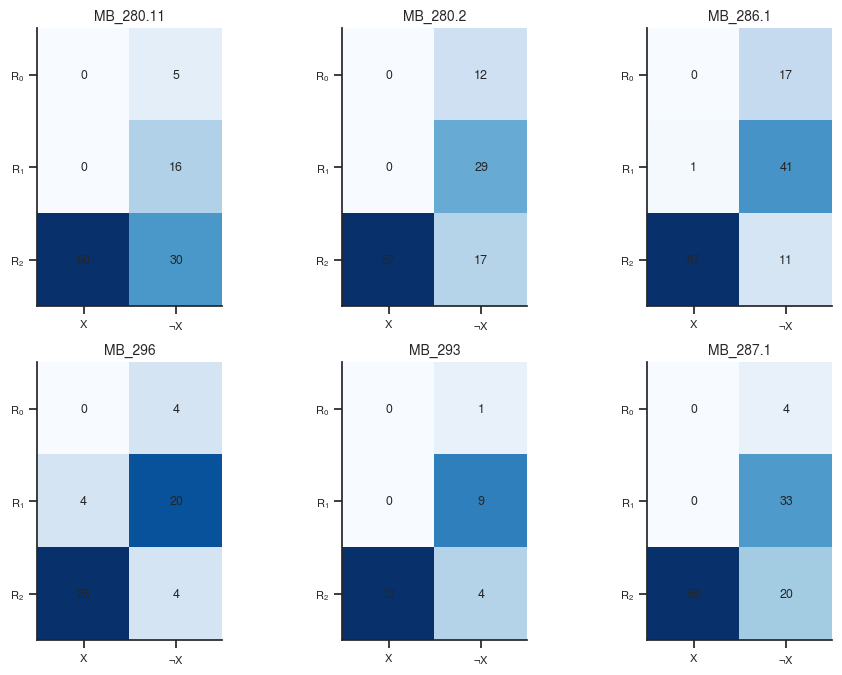

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- setup ----------------------------------------------------------
d = trunc.copy()
d["rel_num"] = pd.to_numeric(d["relevant"], errors="coerce")
d = d[~d["rel_num"].isna()]  # keep rows physicians labeled
d["is_x"] = d["is_known"] == 1  # in PhecodeX

# ---- per-phecode counts across R0/R1/R2 -----------------------------
def get_counts(g):
    out = {}
    for r in [0, 1, 2]:
        sub = g[g["rel_num"] == r]
        out[f"R{r}_X"] = int(sub["is_x"].sum())       # in PhecodeX
        out[f"R{r}_nX"] = int((~sub["is_x"]).sum())   # not in PhecodeX
    return pd.Series(out)

conf = d.groupby("phecode").apply(get_counts).reset_index()

# ---- plotting function ----------------------------------------------
def plot_cm_R(row, title=None, normalize=None):
    """
    Confusion matrix by physician relevance (rows: R0,R1,R2)
    vs PhecodeX inclusion (columns: X / ¬X)
    """
    cm = np.array([
        [row["R0_X"], row["R0_nX"]],
        [row["R1_X"], row["R1_nX"]],
        [row["R2_X"], row["R2_nX"]],
    ], dtype=float)

    if normalize == "pred":      cm = cm / cm.sum(axis=0, keepdims=True)
    elif normalize == "actual":  cm = cm / cm.sum(axis=1, keepdims=True)
    elif normalize == "all":     cm = cm / cm.sum()

    fig, ax = plt.subplots(figsize=(3.4, 3.6))
    im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=cm.max() if normalize else None)

    # cell text
    for (i, j), v in np.ndenumerate(cm):
        txt = f"{v:.2f}" if normalize else f"{int(v)}"
        ax.text(j, i, txt, ha="center", va="center", fontsize=10)

    # LaTeX tick labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["X", r"$\neg X$"])  # predicted: in map / not in map
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([r"$R_0$", r"$R_1$", r"$R_2$"])

    ax.set_xlabel("PhecodeX")
    ax.set_ylabel("Physician annotation")
    ax.set_title(title or "Confusion matrix by relevance", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig, ax

# ---- small multiples -----------------------------------------------
targets = ["MB_280.11","MB_280.2","MB_286.1","MB_296","MB_293","MB_287.1"]
rows = conf.set_index("phecode").loc[targets]

n = len(rows)
cols = 3
r = int(np.ceil(n / cols))
fig, axes = plt.subplots(r, cols, figsize=(3.2 * cols, 3.4 * r))
axes = np.atleast_1d(axes).ravel()

for ax, (phe, row) in zip(axes, rows.iterrows()):
    cm = np.array([
        [row.R0_X, row.R0_nX],
        [row.R1_X, row.R1_nX],
        [row.R2_X, row.R2_nX],
    ])
    im = ax.imshow(cm, cmap="Blues")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(int(v)), ha="center", va="center", fontsize=9)
    ax.set_xticks([0, 1]); ax.set_xticklabels(["X", r"$\neg X$"])
    ax.set_yticks([0, 1, 2]); ax.set_yticklabels([r"$R_0$", r"$R_1$", r"$R_2$"])
    ax.set_title(phe, fontsize=10)
    # ax.set_xlabel("PhecodeX"); ax.set_ylabel("Reviewed Phecoder output up to 50% PPV")

for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


there is more nuance needed to the bar plot below. For example the below line clearly shows the sizes are wrong in the plot

# Supplementary Figure 1

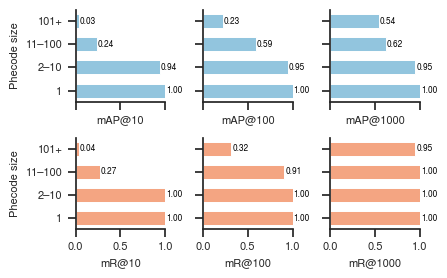

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric_dict = {"Recall": "R@k", "AP": "AP@k"}
best_model = "Qwen3-Embedding-4B"

metrics_best = master_metrics_df[master_metrics_df["model"] == best_model].copy()

# --- log-scale bins ---
max_n_gold_pos = metrics_best['n_gold_pos'].max()
bins = [0, 1, 10, 100, max_n_gold_pos]
labels = [r"1", r"2–10", r"11–100", rf"101+"]
metrics_best["icd_bin"] = pd.cut(metrics_best["n_gold_pos"], bins=bins, labels=labels, right=True)

# top row = AP, bottom row = Recall
plots = [
    ("AP", 10),
    ("AP", 100),
    ("AP", 1000),
    ("Recall", 10),
    ("Recall", 100),
    ("Recall", 1000),
]

# ───────────────────────────── 2×3 subplots ───────────────────────────── #
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(4.75, 3),
    sharex=True, sharey=True
)
axes = axes.flatten()

for i, (ax, (metric, k)) in enumerate(zip(axes, plots)):
    metric_caps = ''.join([c for c in metric if c.isupper()])
    metric_k = f"{metric_caps}@{k}"
    df_temp = metrics_best[metrics_best["k"] == k]

    medians = (
        df_temp.groupby("icd_bin", observed=True)[metric_dict[metric]]
        .median()
        .sort_index()
    )

    bins_order = medians.index.tolist()
    values = medians.values
    color = "#92c5de" if metric == "AP" else "#f4a582"

    ax.barh(
        bins_order, values,
        color=color, edgecolor="white", linewidth=0.7, height=0.6
    )

    for y, val in zip(bins_order, values):
        ax.text(val + 0.01, y, f"{val:.2f}",
                va="center", ha="left", fontsize=6, color="black")

    ax.set_xlim(0, 1)
    ax.set_xlabel(f"m{metric_k}", fontsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    # y-labels only on left column
    if i % 3 == 0:
        ax.set_ylabel("Phecode size", fontsize=8)
    else:
        ax.set_ylabel("")
        ax.tick_params(axis="y", labelleft=False)

plt.tight_layout(rect=[0.05, 0.06, 1, 1])

for ext in ["png", "pdf"]:
    plt.savefig(f"../figures/sup_logbins_bars.{ext}", dpi=300)
plt.show()


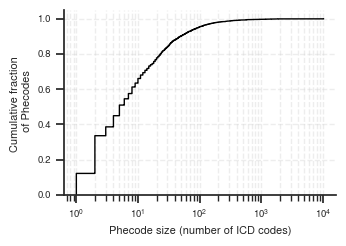

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# assuming master_metrics_df exists
# extract unique phecodes and their ICD counts
phecode_icd_counts = (
    master_metrics_df[["phecode", "n_gold_pos"]]
    .drop_duplicates(subset="phecode")
    .set_index("phecode")["n_gold_pos"]
)

# sort ascending
sorted_counts = np.sort(phecode_icd_counts)
n = len(sorted_counts)
cdf = np.arange(1, n + 1) / n  # cumulative fraction of phecodes

# plot
plt.figure(figsize=(3.5, 2.5))
plt.plot(sorted_counts, cdf, drawstyle="steps-post", lw=1, color="black")

plt.xscale("log")
plt.xlabel("Phecode size (number of ICD codes)", fontsize=8)
plt.ylabel("Cumulative fraction \n of Phecodes", fontsize=8)
plt.tick_params(axis="x", labelsize=7)
plt.tick_params(axis="y", labelsize=7)
plt.ylim(0)

plt.grid(True, which="both", linestyle="--", alpha=0.4, color='lightgray')
plt.tight_layout()

# save
for extension in ['png', 'pdf']:
    plt.savefig(f"../figures/sup_phecode_cdf.{extension}", dpi=300)


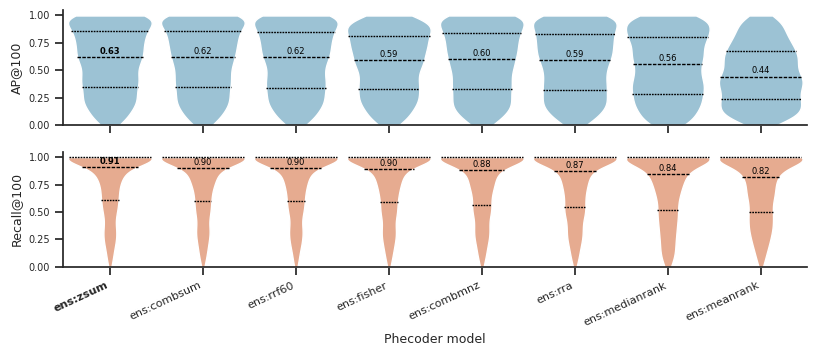

# old code

In [ ]:
# old code

In [ ]:


xls = pd.ExcelFile("/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_final_annotated.xlsx")
# --- prepare a dict to hold updated sheets ---
updated_sheets = {}

for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, dtype={"icd_code": str})

    df['icd_code'] = df['icd_code'].astype("string[python]")
    df["icd_code"] = df["icd_code"].str.replace(r"\.$", "", regex=True)
    df['icd_string'] = df['icd_string'].astype("string[python]")

    # merge on icd_code and icd_string
    merged = df.drop(columns=['flag'], errors='ignore').merge(
        icd_info[['icd_code', 'icd_string', 'flag']],
        on=['icd_code', 'icd_string'],
        how='left',  # keeps all rows from df
    )

    updated_sheets[sheet_name] = merged
with pd.ExcelWriter("/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_final_annotated_fixed.xlsx") as writer:
    for name, data in updated_sheets.items():
        data.to_excel(writer, sheet_name=name, index=False)
- Load results for ensemble.
- Merge annotations on 'icd_code, icd_string'.
- Add 
annotations_all.columns
sim_df.merge(annotations_all, on=['phecode', 'icd_code', 'icd_string'], how='left')
df = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/icd_info_new.parquet')

# Old code

get current annotations

In [96]:
# Load all sheets into a dict
annotations_dict = pd.read_excel(
    "/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_2.xlsx",
    sheet_name=None,
    dtype={"icd_code": str}
)

frames = []

for sheet_name, df in annotations_dict.items():
    # Extract phecode inside brackets, e.g. "Eating disorders (MB_293)" → "MB_293"
    m = re.search(r"\((.*?)\)", sheet_name)
    phecode = m.group(1) if m else None
    # Add as a column
    df = df.copy()
    df["phecode"] = phecode
    
    frames.append(df)

# Concatenate into one long DataFrame
annotations_all = pd.concat(frames, ignore_index=True)

get 50% ppv ranks

In [97]:
metrics = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/results/case_studies/metrics.parquet')
pr_curves = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/results/case_studies/pr_curves.parquet')

threshold = 0.5
ppv_df = []

for _, row in pr_curves.iterrows():
    model = row["model"]
    phecode = row["phecode"]
    precisions = row["curve_precision"]

    # find first index >= 11 where precision < threshold
    cutoff_idx = next(
        (i for i, p in enumerate(precisions, start=1) if i > 10 and p < threshold),
        None
    )

    ppv_df.append({
        "model": model,
        "phecode": phecode,
        "cutoff_rank": cutoff_idx
    })

ppv_df = pd.DataFrame(ppv_df)


load recs and apply 50% ppv cut off

In [98]:
rec_files = glob.glob("/sc/arion/projects/va-biobank/jamie/phecoder/results/case_studies/**/similarity.parquet", recursive=True)
recs = pd.concat(pd.read_parquet(file) for file in rec_files)

# Merge cutoffs into recs
recs_cut = recs.merge(ppv_df, on=["model", "phecode"], how="left")

# Keep only rows up to cutoff (or all if cutoff is None)
recs_truncated = recs_cut[
    recs_cut["cutoff_rank"].isna() | (recs_cut["rank"] < recs_cut["cutoff_rank"])
].copy()

# Drop helper column if you don’t want it
recs_truncated = recs_truncated.drop(columns=["cutoff_rank"])

In [60]:
test = recs_truncated
models = [
    "Alibaba-NLP/gte-Qwen2-7B-instruct", # best model on MTEB leaderboard (Medical)
    "infly/inf-retriever-v1", # best model on MTEB leaderboard (Medical) for information retrieval
    "all-MiniLM-L6-v2", # original SentenceTransformer model: best across all datasets tested. No clinical motivation (train or evaluation)
    "sentence-t5-xxl",  # original SentenceTransformer model: tuned for sentence embedding task. No clinical motivation (train or evaluation)
    "multi-qa-mpnet-base-dot-v1", # original SentenceTransformer model: tuned for semantic search task. No clinical motivation (train or evaluation)
    "NeuML/pubmedbert-base-embeddings",  # trained on PubMed
    "FremyCompany/BioLORD-2023",  # model trained specifically on clinical sentences and biomedical concepts
]
test = test[test['model'].isin(models)]
# test = test[test['phecode']=='MB_280.11']

In [61]:
phecode_icd_lookup = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_icd_pairs.parquet')

In [62]:
len(test[['icd_code', 'icd_string']].drop_duplicates())

630

In [63]:
len(set(test['icd_code'].drop_duplicates().tolist()) | set(phecode_icd_lookup[phecode_icd_lookup['phecode']=='MB_280.11']['icd_code'].tolist()))

644

create new validation df to be annotated 

In [64]:
# recs_truncated = test

In [99]:
# Universe of pairs from recs
pairs = recs_truncated[['phecode', 'icd_code', 'icd_string']].drop_duplicates()

# Merge annotations (keeping only one row per pair)
annotations_dedup = annotations_all.drop_duplicates(subset=['phecode','icd_code'])

phecoder_validation_2 = pairs.merge(
    annotations_dedup,
    on=['phecode','icd_code'],
    how='left',
    suffixes=('', '_annot')
)
phecoder_validation_2 = phecoder_validation_2.drop('icd_string_annot', axis=1)
print(len(phecoder_validation_2), len(pairs))

1118 1118


In [72]:
phecoder_validation_2[phecoder_validation_2['relevant'].isna()].head(60)

,phecode,icd_code,icd_string,flag,relevant,comments
30,MB_280.11,G31.2,Degeneration of nervous system due to alcohol,NaN,NaN,NaN
33,MB_280.11,F11.23,Opioid dependence with withdrawal,NaN,NaN,NaN
38,MB_280.11,571.2,ALCOHOLIC CIRRHOSIS OF LIVER,NaN,NaN,NaN
39,MB_280.11,357.5,ALCOHOLIC POLYNEUROPATHY,NaN,NaN,NaN
40,MB_280.11,G62.1,Alcoholic polyneuropathy,NaN,NaN,NaN
42,MB_280.11,K70.2,Alcoholic fibrosis and sclerosis of liver,NaN,NaN,NaN
44,MB_280.11,K86.0,Alcohol-induced chronic pancreatitis,NaN,NaN,NaN
45,MB_280.11,K70.0,Alcoholic fatty liver,NaN,NaN,NaN
51,MB_280.11,F11.13,Opioid abuse with withdrawal,NaN,NaN,NaN
55,MB_280.11,G72.1,Alcoholic myopathy,NaN,NaN,NaN


In [100]:
# Choose column that defines the sheets
split_col = "category"

# Save to Excel, each sheet = one category
output_file = "output.xlsx"
with pd.ExcelWriter(output_file) as writer:
    for key, sub_df in phecoder_validation_2.groupby('phecode'):
        # Excel sheet names must be <= 31 chars and not contain [ ] : * ? / \
        safe_key = str(key)
        df = sub_df.sort_values('relevant', ascending=True)
        df.to_excel(writer, sheet_name=safe_key, index=False)


In [25]:
annotations_dedup[annotations_dedup['icd_code']=='994.2']

,icd_code,icd_string,flag,relevant,comments,phecode
37,994.2,EFFECTS OF HUNGER,9,1,can occur in severe AN,MB_293


Idea for plot. Plot correlation between similarity scores (top_100 maybe top_1000)

In [123]:
model = 'infly/inf-retriever-v1'
# model = 'FremyCompany/BioLORD-2023'
phecode = 'MB_286.1'

pr_curve_example = pr_curves[(pr_curves['phecode']==phecode)&(pr_curves['model']==model)]
precision = pr_curve_example['curve_precision'].iat[0]
recall = pr_curve_example['curve_recall'].iat[0]

metrics_example = metrics[(metrics['phecode']==phecode)&(metrics['model']==model)]

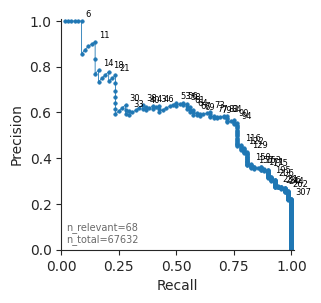

In [122]:
import numpy as np
import matplotlib.pyplot as plt

pr_curve_example = pr_curves[
    (pr_curves['phecode'] == phecode) & (pr_curves['model'] == model)
]
precision = np.array(pr_curve_example['curve_precision'].iat[0])
recall    = np.array(pr_curve_example['curve_recall'].iat[0])

# grab gold count from metrics_example
n_gold = metrics_example['n_gold_pos'].iat[0]
n_considered = metrics_example['n_considered'].iat[0]

plt.figure(figsize=(3,3))
plt.plot(
    recall, 
    precision, 
    marker="o", 
    markersize=2.5, 
    markeredgewidth=0.5, 
    linewidth=0.6, 
    label="PR curve"
)

# --- annotate edges (first index before each downward run) ---
drops = np.where(np.diff(precision) < 0)[0]
edge_idx = drops[np.insert(np.diff(drops) > 1, 0, True)]
for i in edge_idx:
    if precision[i] > 0.0:
        rank = i + 1
        plt.annotate(
            f"{rank}",
            (recall[i], precision[i]),
            textcoords="offset points",
            xytext=(3,3),
            fontsize=6,
            color="black"
        )

# --- overlay total ground truth count ---
plt.text(
    0.02, 0.02, 
    f"n_relevant={n_gold}\nn_total={n_considered}", 
    transform=plt.gca().transAxes,
    ha="left", va="bottom", fontsize=7, color="dimgray"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.show()


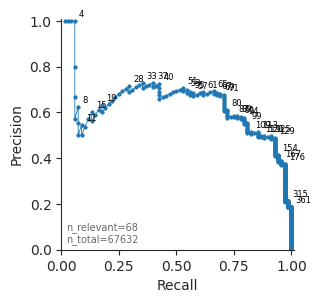

In [124]:
import numpy as np
import matplotlib.pyplot as plt

pr_curve_example = pr_curves[
    (pr_curves['phecode'] == phecode) & (pr_curves['model'] == model)
]
precision = np.array(pr_curve_example['curve_precision'].iat[0])
recall    = np.array(pr_curve_example['curve_recall'].iat[0])

# grab gold count from metrics_example
n_gold = metrics_example['n_gold_pos'].iat[0]
n_considered = metrics_example['n_considered'].iat[0]

plt.figure(figsize=(3,3))
plt.plot(
    recall, 
    precision, 
    marker="o", 
    markersize=2.5, 
    markeredgewidth=0.5, 
    linewidth=0.6, 
    label="PR curve"
)

# --- annotate edges (first index before each downward run) ---
drops = np.where(np.diff(precision) < 0)[0]
edge_idx = drops[np.insert(np.diff(drops) > 1, 0, True)]
for i in edge_idx:
    if precision[i] > 0.0:
        rank = i + 1
        plt.annotate(
            f"{rank}",
            (recall[i], precision[i]),
            textcoords="offset points",
            xytext=(3,3),
            fontsize=6,
            color="black"
        )

# --- overlay total ground truth count ---
plt.text(
    0.02, 0.02, 
    f"n_relevant={n_gold}\nn_total={n_considered}", 
    transform=plt.gca().transAxes,
    ha="left", va="bottom", fontsize=7, color="dimgray"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.show()


In [14]:
phecode_ground_truth = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/phecode_icd_pairs.parquet')
icd_df = pd.read_parquet('/sc/arion/projects/va-biobank/jamie/phecoder/data/processed/phecodeX/icd_info.parquet')

In [15]:
phecode_ground_truth_trunc = phecode_ground_truth[phecode_ground_truth['icd_code'].isin(icd_df['icd_code'])]

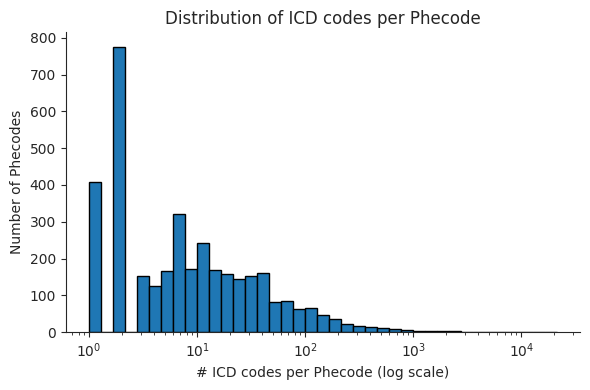

In [39]:
import matplotlib.pyplot as plt
import numpy as np

icd_counts = phecode_ground_truth.value_counts('phecode')

plt.figure(figsize=(6,4))

# Choose log-spaced bins: e.g. 1, 2, 5, 10, 20, 50, 100, ...
bins = np.logspace(
    np.log10(icd_counts.min()), 
    np.log10(icd_counts.max()), 
    40  # number of bins (adjust if needed)
)

plt.hist(icd_counts, bins=bins, edgecolor="black")
plt.xscale("log")  # 👈 log-scale x-axis

plt.title("Distribution of ICD codes per Phecode")
plt.xlabel("# ICD codes per Phecode (log scale)")
plt.ylabel("Number of Phecodes")
plt.tight_layout()
plt.show()


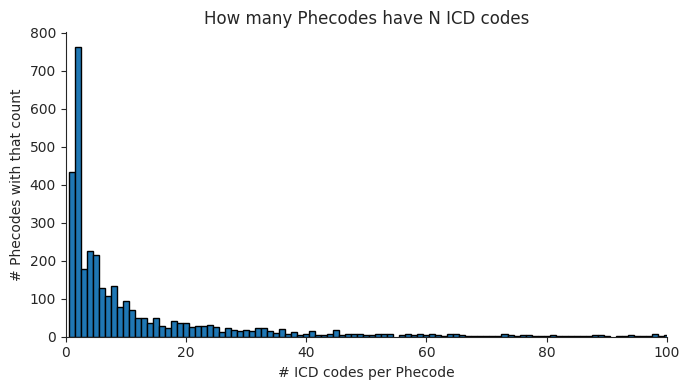

In [32]:
import matplotlib.pyplot as plt

# Get frequency of each count value
freq = icd_counts.value_counts().sort_index()

plt.figure(figsize=(7,4))
plt.bar(freq.index, freq.values, width=1, edgecolor='black')
plt.xlabel("# ICD codes per Phecode")
plt.ylabel("# Phecodes with that count")
plt.title("How many Phecodes have N ICD codes")
# plt.yscale("log")  # optional if there's a huge left spike
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

In [40]:
n_over_10 = (icd_counts > 10).sum()

In [41]:
n_over_10

np.int64(1398)

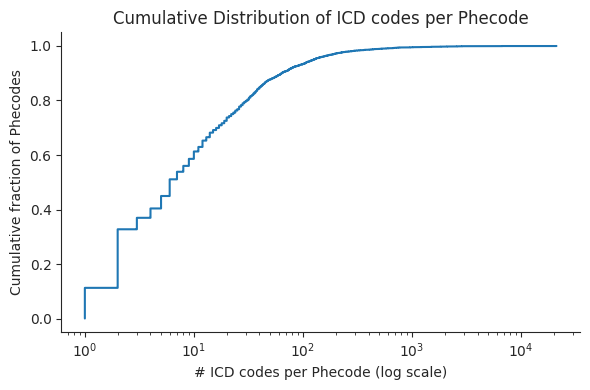

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# sort counts ascending
sorted_counts = np.sort(icd_counts)
n = len(sorted_counts)
cdf = np.arange(1, n + 1) / n  # cumulative fraction of phecodes

plt.figure(figsize=(6,4))
plt.plot(sorted_counts, cdf, drawstyle="steps-post")
plt.xscale("log")
plt.xlabel("# ICD codes per Phecode (log scale)")
plt.ylabel("Cumulative fraction of Phecodes")
plt.title("Cumulative Distribution of ICD codes per Phecode")

plt.tight_layout()
plt.show()


In [3]:
from phecoder import Phecoder
from phecoder.utils import list_runs, load_data

/sc/arion/projects/va-biobank/jamie/phecoder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'utils'

In [112]:
import pandas as pd

def load_annotations_with_phecode(path: str) -> pd.DataFrame:
    """
    Load multi-sheet annotation Excel file into a single DataFrame.
    Assumes each sheet has columns ['phecode', 'icd_code', 'icd_string'].
    """
    annotations_dict = pd.read_excel(
        path, sheet_name=None,
        dtype={"icd_code": str, "phecode": str, "icd_string": str}
    )
    frames = []

    for sheet_name, df in annotations_dict.items():
        df = df.copy()
        # keep only expected columns if they exist
        keep_cols = [col for col in ["phecode", "icd_code", "icd_string"] if col in df.columns]
        if not keep_cols:
            continue
        frames.append(df[keep_cols])

    return pd.concat(frames, ignore_index=True).drop_duplicates()


# --- Load both versions ---
annotations_v1 = load_annotations_with_phecode(
    "/sc/arion/projects/va-biobank/jamie/phecoder/validation/phecoder_validation_ST_2.xlsx"
)
annotations_v2 = load_annotations_with_phecode(
    "/sc/arion/projects/va-biobank/jamie/phecoder/notebooks/output.xlsx"
)

# --- Compare the two ---
key_cols = ["phecode", "icd_code"]  # used for matching
new_rows = (
    annotations_v2
    .merge(annotations_v1[key_cols], on=key_cols, how="left", indicator=True)
    .query("_merge == 'left_only'")
    .drop(columns="_merge")
)

print(f"New ICD mappings found: {len(new_rows)}")



New ICD mappings found: 9


In [114]:
new_rows.to_csv('output.csv')

In [109]:
annotations_v2

,phecode,icd_code
0,None,304.22
1,None,304.32
2,None,F17.213
3,None,304.30
4,None,F17.228
...,...,...
1109,None,V11.9
1114,None,309.3
1115,None,F43.24
1116,None,294.8
